In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
%run func_DL.py

In [ ]:
print(torch.cuda.is_available())

---

### model

In [ ]:
class model_task3(nn.Module):
    def __init__(self, in_channels, in_length, out_channels, out_length, batch_size):
        super().__init__()
        #-----------------------------------
        #var
        self.in_channels = in_channels
        self.in_length = in_length
        self.out_channels = out_channels
        self.out_length = out_length
        self.batch_size = batch_size
        #-----------------------------------
        #Conv1d
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        #https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        #conv1d_0
        kernel_size_conv1d_0=100; stride_conv1d_0=5; padding_conv1d_0=1; dilation_conv1d_0=1; 
        self.in_channels_conv1d_0 = self.in_channels; self.in_length_conv1d_0 = self.in_length
        self.out_channels_conv1d_0= 50; self.out_length_conv1d_0 = int((self.in_length_conv1d_0+2*padding_conv1d_0-dilation_conv1d_0*(kernel_size_conv1d_0-1)-1)/stride_conv1d_0+1)
        #conv1d_1
        kernel_size_conv1d_1=50; stride_conv1d_1=3; padding_conv1d_1=1; dilation_conv1d_1=1; 
        self.in_channels_conv1d_1 = self.out_channels_conv1d_0; self.in_length_conv1d_1 = self.out_length_conv1d_0
        self.out_channels_conv1d_1= 30; self.out_length_conv1d_1= int((self.in_length_conv1d_1+2*padding_conv1d_1-dilation_conv1d_1*(kernel_size_conv1d_1-1)-1)/stride_conv1d_1+1)
        #conv1d_2
        kernel_size_conv1d_2=3; stride_conv1d_2=1; padding_conv1d_2=1; dilation_conv1d_2=1; 
        self.in_channels_conv1d_2 = self.out_channels_conv1d_1; self.in_length_conv1d_2 = self.out_length_conv1d_1
        self.out_channels_conv1d_2= 10; self.out_length_conv1d_2= int((self.in_length_conv1d_2+2*padding_conv1d_2-dilation_conv1d_2*(kernel_size_conv1d_2-1)-1)/stride_conv1d_2+1)
        #-----------------------------------
        #DNN
        self.in_channels_DNN = self.out_channels_conv1d_2*self.out_length_conv1d_2
        self.inner_channels_DNN = 30
        self.out_channels_DNN = self.out_channels*self.out_length

        #-----------------------------------
        #layer0
        self.layer0 = nn.Sequential(
            #-----------------------------------
            #conv1d_0
            nn.Conv1d(in_channels=self.in_channels_conv1d_0, out_channels=self.out_channels_conv1d_0, kernel_size=kernel_size_conv1d_0, stride=stride_conv1d_0, padding=padding_conv1d_0, dilation=dilation_conv1d_0),
            nn.BatchNorm1d(num_features=self.out_channels_conv1d_0),
            nn.ReLU(),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, inplace=True),
            #-----------------------------------
            #conv1d_1
            #nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=self.in_channels_conv1d_1, out_channels=self.out_channels_conv1d_1, kernel_size=kernel_size_conv1d_1, stride=stride_conv1d_1, padding=padding_conv1d_1, dilation=dilation_conv1d_1),
            nn.BatchNorm1d(num_features=self.out_channels_conv1d_1),
            nn.ReLU(),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, inplace=True),
            #-----------------------------------
            #conv1d_2
            nn.Conv1d(in_channels=self.in_channels_conv1d_2, out_channels=self.out_channels_conv1d_2, kernel_size=kernel_size_conv1d_2, stride=stride_conv1d_2, padding=padding_conv1d_2, dilation=dilation_conv1d_2),
            nn.BatchNorm1d(num_features=self.out_channels_conv1d_2),
            nn.ReLU(),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, inplace=True),
        )
        #-----------------------------------
        #layer1
        self.layer1 = nn.Sequential(
            #-----------------------------------
            nn.Linear(self.in_channels_DNN, self.inner_channels_DNN),
            nn.BatchNorm1d(num_features=self.inner_channels_DNN),
            #nn.ReLU(),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Sigmoid(),
            #-----------------------------------
            #nn.Dropout(p=0.2),
            #nn.Linear(self.inner_channels_DNN, self.inner_channels_DNN),
            #nn.ReLU(),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Sigmoid(),
            #-----------------------------------
            nn.Linear(self.inner_channels_DNN, self.out_channels_DNN),
            #nn.ReLU(),
            nn.Sigmoid(),            
        )


    def forward(self, x):    
        output0 = self.layer0(x).view(-1, self.in_channels_DNN)
        output1 = self.layer1(output0).view(-1, self.out_channels, self.out_length)
        return output1

In [ ]:
"""class model_1(nn.Module):
    def __init__(self, in_channels, in_length, out_channels, out_length, batch_size):
        super().__init__()
        #-----------------------------------
        #var
        self.in_channels = in_channels
        self.in_length = in_length
        self.out_channels = out_channels
        self.out_length = out_length
        self.batch_size = batch_size
        #-----------------------------------
        #Conv1d
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        #https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        self.in_channels_inner_0 = self.in_channels; self.in_length_inner_0 = self.in_length
        kernel_size=200; stride=50; padding=1; dilation=1; 
        self.out_channels_inner_0 = 30; self.out_length_inner_0 = int((self.in_length_inner_0+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        self.conv1d = nn.Conv1d(in_channels=self.in_channels_inner_0, out_channels=self.out_channels_inner_0, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        #-----------------------------------
        #DNN
        self.in_channels_inner_1 = self.out_channels_inner_0*self.out_length_inner_0
        self.out_channels_inner_1 = self.out_channels*self.out_length

        #-----------------------------------
        #layer0
        self.layer0 = nn.Sequential(
            #-----------------------------------
            nn.Conv1d(in_channels=self.in_channels_inner_0, out_channels=self.out_channels_inner_0, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.ReLU(),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(num_features=self.out_channels_inner_0),
        )
        #-----------------------------------
        #layer1
        self.layer1 = nn.Sequential(
            #-----------------------------------
            nn.Linear(self.in_channels_inner_1, self.out_channels_inner_1),
            #nn.ReLU(),
            #nn.Sigmoid(),
        )

    def forward(self, x):
        #for i in range(5):
        output0 = self.layer0(x).view(-1, self.in_channels_inner_1)
        output1 = self.layer1(output0).view(-1, self.out_channels, self.out_length)
        return output1"""

In [ ]:
"""class model_2(nn.Module):
    def __init__(self, in_channels, in_length, out_channels, out_length, batch_size):
        super().__init__()
        #-----------------------------------
        #var
        self.in_channels = in_channels
        self.in_length = in_length
        self.out_channels = out_channels
        self.out_length = out_length
        self.batch_size = batch_size
        #-----------------------------------
        #DNN
        self.in_channels_inner_1 = self.in_channels*self.in_length
        self.out_channels_inner_1 = 30
        #-----------------------------------
        #DNN
        self.in_channels_inner_2 = self.out_channels_inner_1
        self.out_channels_inner_2 = self.out_channels*self.out_length
        #-----------------------------------
        #layer1
        self.layer1 = nn.Sequential(
            #-----------------------------------
            nn.BatchNorm1d(num_features=self.in_channels_inner_1),
            nn.Linear(self.in_channels_inner_1, self.out_channels_inner_1),
            nn.ReLU(),
            nn.Sigmoid(),
        )
        #-----------------------------------
        #layer2
        self.layer2 = nn.Sequential(
            #-----------------------------------
            nn.BatchNorm1d(num_features=self.in_channels_inner_2),
            nn.Linear(self.in_channels_inner_2, self.out_channels_inner_2),
            nn.ReLU(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, self.in_channels_inner_1)
        output1 = self.layer1(x)
        output2 = self.layer2(output1)
        output2 = output2.view(-1, self.out_channels, self.out_length)
        return output2"""

### dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

#---------------------------------------------
#var
path_dir_X = "../data_X"
path_dir_Y = "../data_Y_Task3"
n_test = 100
n_val = 100
batch_size = 5000

#---------------------------------------------
#instance
dataset = CustomDataset(path_dir_X=path_dir_X, path_dir_Y=path_dir_Y, n_test=n_test, n_val=n_val, batch_size=batch_size)
dataloder = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### var, init

In [ ]:
#----------------------------
#var (condition)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#----------------------------
#var (train)
num_epochs = 1000
n_print_train_result = 1
val_flag = True

#----------------------------
#init (model)
in_channels = dataset.return_shape_X()[0]
in_length = dataset.return_shape_X()[1]
out_channels = dataset.return_shape_Y()[0]
out_length = dataset.return_shape_Y()[1]
model = model_task3(in_channels, in_length, out_channels, out_length, batch_size).to(device)
#init model weight
model.apply(init_normal_dist)
#----------------------------
#init (optimizer, scheduler)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,50,100,300,500], gamma=0.9)
#----------------------------
#init (loss_func)
#https://neptune.ai/blog/pytorch-loss-functions
loss_func = nn.MSELoss()
#loss_func = nn.L1Loss()

### train

In [ ]:
#----------------------------
#results
history = {"train_loss": [], "val_loss": []}

#----------------------------
#学習
for epoch in range(num_epochs):
  #----------------------------
  # train
  model.train()
  for i, (x, y) in enumerate(dataloder):
    #----------------------------
    #float32, grad==True
    x = dataset.change_data_setting_to_train(x)
    y = dataset.change_data_setting_to_train(y)
    #----------------------------
    #change the type
    x = x.to(device)
    y = y.to(device)
    #----------------------------
    #forward
    output = model(x)
    loss = loss_func(output, y)
    #----------------------------
    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #----------------------------
    #print & result
    if (i+1) % n_print_train_result == 0:
      print(f'Epoch: {epoch+1}, iter: {i+1}, train_loss: {loss: 0.4f}')
      print(x.grad.mean())
  history["train_loss"].append(loss)

  #----------------------------
  # eval
  if val_flag == True:
    model.eval()
    with torch.no_grad():
      #----------------------------
      #forward
      x, y = dataset.return_val_data()
      #----------------------------
      #float32, grad==True
      x = dataset.change_data_setting_to_train(x)
      y = dataset.change_data_setting_to_train(y)
      #----------------------------
      #change the type
      x = x.to(device)
      y = y.to(device)
      #----------------------------
      #forward
      output = model(x)
      loss = loss_func(output, y)
      #----------------------------
      #print & result
      history["val_loss"].append(loss)
      print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  #----------------------------
  # scheduler
  scheduler.step()

### result_train

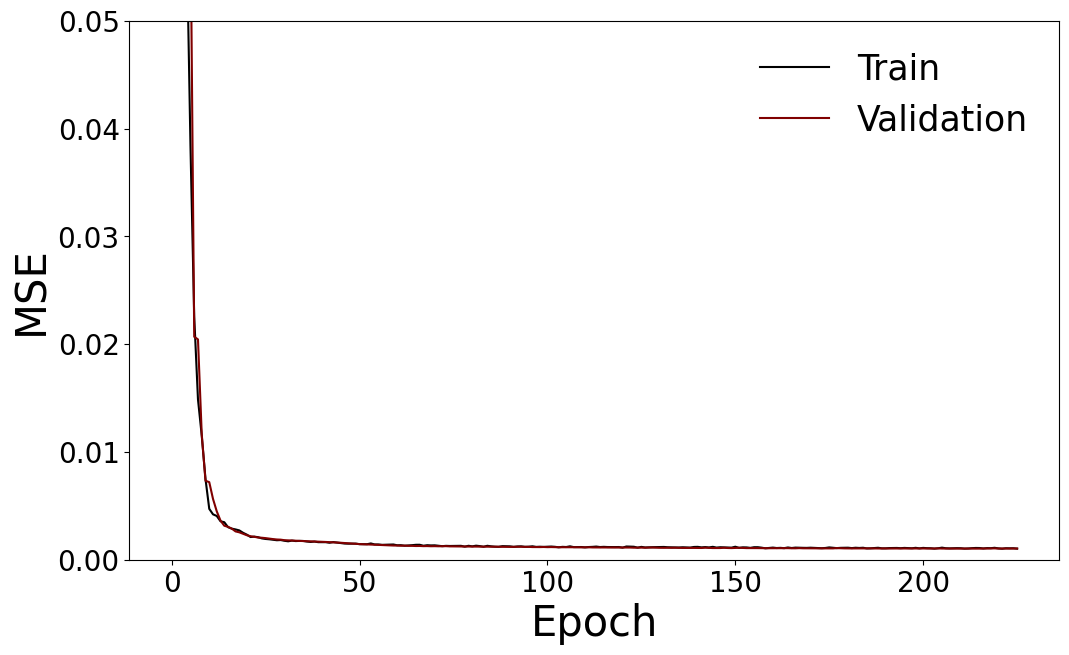

In [32]:
#----------------------------
#make data (train)
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
#----------------------------
#make data (val)
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()

#----------------------------
#plot
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
ax.plot(train_loss_np, color="black",label="Train")
ax.plot(val_loss_np, color="maroon",label="Validation")
#plot (setting)
ax.tick_params(labelsize=20)
ax.set_xlabel("Epoch", fontsize=30)
ax.set_ylabel("MSE", fontsize=30)
ax.legend(fontsize=25, frameon=False)
ax.set_ylim(0,0.05)
plt.show()

### result_test

In [28]:
from sklearn.metrics import r2_score, mean_squared_error

#----------------------------
# eval
model.eval()
with torch.no_grad():
    #----------------------------
    #forward
    x, y = dataset.return_test_data()
    #----------------------------
    #float32, grad==True
    x = dataset.change_data_setting_to_train(x)
    y = dataset.change_data_setting_to_train(y)
    #----------------------------
    #change the type
    x = x.to(device)
    y = y.to(device)
    #----------------------------
    #forward
    output = model(x)
    #----------------------------
    #change to numpy
    output = output.to('cpu').detach().numpy().copy().flatten()
    y = y.to('cpu').detach().numpy().copy().flatten()
    loss_MSE = mean_squared_error(output, y)
    loss_R2 = r2_score(output, y)
    #----------------------------
    #print loss
    print("MSE: ", loss_MSE)  
    print("R2: ", loss_R2)

MSE:  0.0009638598
R2:  0.6785004138946533


### plot_test (true/pred)

In [35]:
from sklearn.metrics import r2_score # スコア計算
from sklearn.metrics import mean_absolute_error # スコア計算 (MAE)
from sklearn.metrics import mean_squared_error # スコア計算 (MSE)
#----------------
def plot_true_predict_from_y(y_predict_list:pd.DataFrame, y_true_list:pd.DataFrame,
                            title:str, path_save=False) -> None:
    #----------------
    #calc score
    r = np.corrcoef(y_true_list, y_predict_list)[0][1]
    R2 = r2_score(y_true=y_true_list, y_pred=y_predict_list) # 決定係数(R2) #https://bellcurve.jp/statistics/course/9706.html
    MAE = mean_absolute_error(y_true=y_true_list, y_pred=y_predict_list) # 平均絶対誤差(MAE)
    RMSE = np.sqrt(mean_squared_error(y_true=y_true_list, y_pred=y_predict_list)) # 二乗平均平方根誤差(RMSE)
    
    #----------------
    #fig, ax
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    #----------------
    #plot scatter
    #ax.scatter(x=y_predict_list, y=y_true_list, s=40, c="black", marker="o", zorder=10)
    ax.plot(y_predict_list, y_true_list, c="black", marker='.', linestyle="", ms=5, zorder=10)
    #----------------
    #plot 直線
    x=np.linspace( min(min(y_true_list),min(y_predict_list)), max(max(y_true_list),max(y_predict_list)), 10) #listの足し算は結合
    y=x
    ax.plot(x, y, color = "black")
    #----------------
    #plot text
    plt.text(x=0.5, y=0.94, 
             s="$r$={0}, $R^2$={1}, $MAE$={2}, $RMSE$={3}".format("{:.2f}".format(r),
                                                                 "{:.2f}".format(R2),
                                                                "{:.2f}".format(MAE),
                                                                "{:.2f}".format(RMSE)), 
             fontdict=dict(fontsize=25, color="black"), ha='center', transform=ax.transAxes,
             zorder=20)
    #----------------
    #setting
    ax.tick_params(labelsize = 20)#軸の大きさ
    ax.set_xlabel("True",fontsize=30)
    ax.set_ylabel("Predict",fontsize=30)
    plt.title("{0}".format(title), fontsize=30)
    #----------------
    #save
    if path_save != False:
        plt.savefig(path_save, bbox_inches='tight')
    #----------------
    #show
    plt.show()

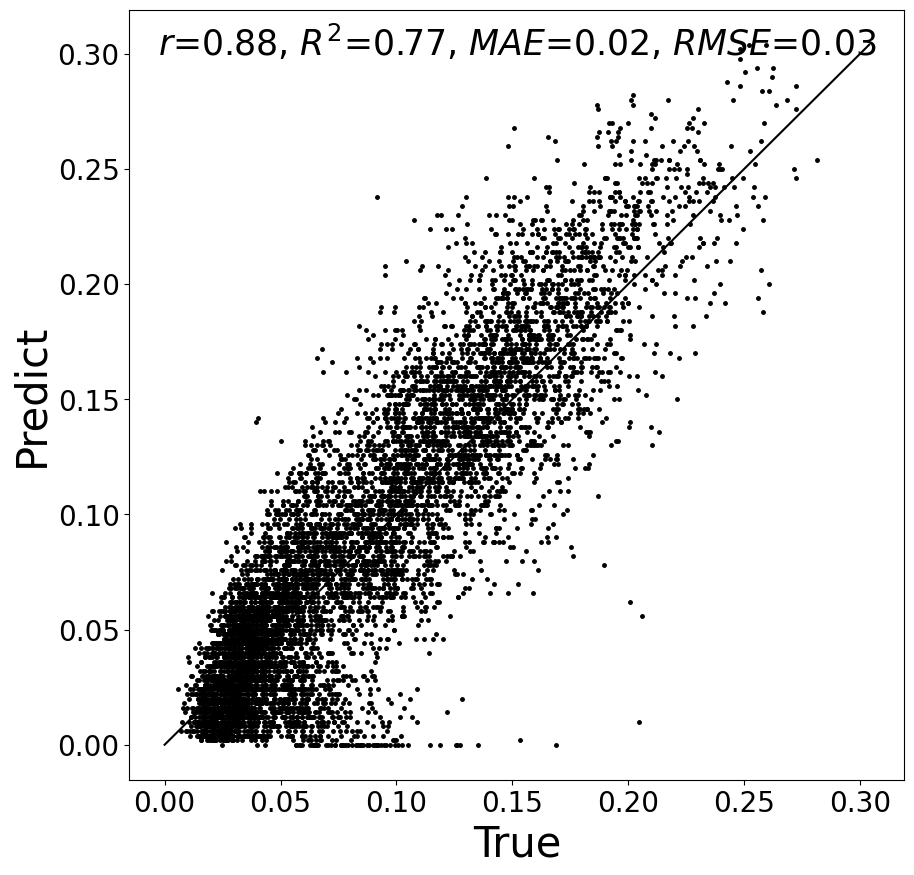

In [36]:
#----------------------------
# eval
model.eval()
with torch.no_grad():
    #----------------------------
    #forward
    x, y = dataset.return_test_data()
    #----------------------------
    #float32, grad==True
    x = dataset.change_data_setting_to_train(x)
    y = dataset.change_data_setting_to_train(y)
    #----------------------------
    #change the type
    x = x.to(device)
    y = y.to(device)
    #----------------------------
    #forward
    output = model(x)
    #----------------------------
    #change to numpy
    output = output.to('cpu').detach().numpy().copy().flatten()
    y = y.to('cpu').detach().numpy().copy().flatten()
    #----------------------------
    #plot
    plot_true_predict_from_y(y_predict_list=output, y_true_list=y, title="", path_save=False) 

### plot_test (sample)

In [ ]:
#def plot_VmDatas_Task3(VmData):

In [ ]:
"""from sklearn.metrics import r2_score, mean_squared_error

#----------------------------
# eval
model.eval()
with torch.no_grad():
    #----------------------------
    #forward
    x, y = dataset.return_test_data()
    #----------------------------
    #float32, grad==True
    x = dataset.change_data_setting_to_train(x)
    y = dataset.change_data_setting_to_train(y)
    #----------------------------
    #change the type
    x = x.to(device)
    y = y.to(device)
    #----------------------------
    #forward
    output = model(x)
    #----------------------------
    #change to numpy
    output = output.to('cpu').detach().numpy().copy().T * 500
    y = y.to('cpu').detach().numpy().copy().T * 500
    #----------------------------
    #plot
    for cnt, (data_true, data_pred) in enumerate(zip(y, output)):
        plot_VmDatas_Task4(data_true)"""

---

# Test (CustomDataset)

In [ ]:
import os, random
from torch.utils.data import Dataset, DataLoader
from typing import Union

#---------------------------------------------
# custom dataset
#https://discuss.pytorch.org/t/custom-data-loader-for-big-data/129361
class CustomDataset(Dataset):
    def __init__(self, path_dir_X:str, path_dir_Y:str, n_test:Union[int,float], n_val:Union[int,float], batch_size:int): # n_test -> float:ratio of test, int:number of test
        #-----------------
        # batch_size
        self.batch_size = batch_size
        # path_dir_X, path_dir_Y
        self.path_dir_X = path_dir_X
        self.path_dir_Y = path_dir_Y
        # list_file_name_all
        self.list_file_name_all = os.listdir(path_dir_X)
        # n_data_all
        self.n_data_all = len(self.list_file_name_all)
        #check
        if len(os.listdir(path_dir_X)) != len(os.listdir(path_dir_Y)):
            raise ValueError("error!!!")
        if len(set(os.listdir(path_dir_X)) - set(os.listdir(path_dir_Y))) != 0:
            raise ValueError("error!!!")
        #-----------------
        # suffle
        random.shuffle(self.list_file_name_all)
        #-----------------
        # n_test
        if type(n_test)==int:
            self.n_test = n_test
        elif type(n_test)==float:
            self.n_test = int(len(self.list_file_name_all)*n_test)
        else:
            raise ValueError("error!!!")
        # n_val
        if type(n_val)==int:
            self.n_val = n_val
        elif type(n_val)==float:
            self.n_val = int(len(self.list_file_name_all)*n_val)
        else:
            raise ValueError("error!!!")
        #check
        if self.n_data_all <= self.n_test+self.n_val:
            raise ValueError("error!!!")
        #-----------------
        # list_file_name_test / _val / _train
        self.list_file_name_test = self.list_file_name_all[:self.n_test]
        self.list_file_name_val = self.list_file_name_all[self.n_test:self.n_test+self.n_val]
        self.list_file_name_train = self.list_file_name_all[self.n_test+self.n_val:]
        
    def __len__(self):
        return len(self.list_file_name_train)
    
    def __getitem__(self, x):
        return self.getdata(list_file_name=self.list_file_name_train, index=x)
    
    def getdata(self, list_file_name, index):
        #file_name
        file_name = list_file_name[index]
        #data_X
        path_file_X = "{0}/{1}".format(self.path_dir_X, file_name)
        data_X = np.load(path_file_X, allow_pickle=True)
        data_X = torch.from_numpy(data_X).to(torch.float32)
        #data_Y
        path_file_Y = "{0}/{1}".format(self.path_dir_Y, file_name)
        data_Y = np.load(path_file_Y, allow_pickle=True)
        data_Y = torch.from_numpy(data_Y).to(torch.float32)
        #return
        return data_X, data_Y
    
    def return_n_data_all(self):
        return self.n_data_all
    
    def return_n_test(self):
        return self.n_test
    
    def return_n_val(self):
        return self.n_val
    
    def return_n_train(self):
        return self.n_data_all - self.n_val - self.n_test
    
    def return_batch_size(self):
        return self.batch_size
    
    def return_shape_X(self):
        data_sample = self.getdata(self.list_file_name_all, 0)[0]
        return data_sample.shape
    
    def return_shape_Y(self):
        data_sample = self.getdata(self.list_file_name_all, 0)[1]
        return data_sample.shape
    
    def return_test_data(self):
        #https://www.tutorialspoint.com/how-to-join-tensors-in-pytorch
        data_X_test = torch.stack([self.getdata(self.list_file_name_test, i)[0] for i in range(self.n_test)])
        data_Y_test = torch.stack([self.getdata(self.list_file_name_test, i)[1] for i in range(self.n_test)])
        return data_X_test, data_Y_test
    
    def return_val_data(self):
        #https://www.tutorialspoint.com/how-to-join-tensors-in-pytorch
        data_X_val = torch.stack([self.getdata(self.list_file_name_val, i)[0] for i in range(self.n_val)])
        data_Y_val = torch.stack([self.getdata(self.list_file_name_val, i)[1] for i in range(self.n_val)])
        return data_X_val, data_Y_val


#---------------------------------------------
#var
path_dir_X = "../data_X"
path_dir_Y = "../data_Y_Task3"
n_test = 100
n_val = 100
batch_size = 10000

#---------------------------------------------
#instance
dataset = CustomDataset(path_dir_X=path_dir_X, path_dir_Y=path_dir_Y, n_test=n_test, n_val=n_val, batch_size=batch_size)
dataloder = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for i, (data_X, data_Y) in enumerate(dataloder):
   # print(data_X.shape, data_Y.shape)
   print(data_Y)

In [ ]:
dataset.return_n_data_all()

In [ ]:
dataset.return_n_test()

In [ ]:
dataset.return_n_val()

In [ ]:
dataset.return_val_data()[1].shape

In [ ]:
dataset.return_test_data()[1].shape

In [ ]:
x,y = dataset.return_val_data()

---

# Test (model)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
class model_1(nn.Module):
    def __init__(self, in_channels, in_length, out_channels, out_length):
        super().__init__()
        #-----------------------------------
        #Conv1d
        in_channels_inner_0 = in_channels; in_length_inner_0 = in_length
        kernel_size=2; stride=1; padding=1; dilation=1; 
        out_channels_inner_0 = 30; out_length_inner_0 = (in_length_inner_0+2*padding-dilation*(kernel_size-1)-1)/stride+1
        self.conv1d = nn.Conv1d(in_channels=in_channels_inner_0, out_channels=out_channels_inner_0, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        #-----------------------------------
        #DNN
        in_channels_inner_1 = out_channels_inner_0*out_length_inner_0; out_channels_inner_1 = out_channels

        #-----------------------------------
        #layer0
        self.layer0 = nn.Sequential(
            #-----------------------------------
            nn.Conv1d(in_channels=in_channels_inner_0, out_channels=out_channels_inner_0, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.relu(),
            nn.BatchNorm1d(out_channels_inner_0*out_length_inner_0),
            #-----------------------------------
            nn.Linear(in_channels_inner_1, out_channels_inner_1),
            nn.relu(),
            nn.Sigmoid()
            #nn.BatchNorm1d(self.params_size+self.features_size),
            #nn.BatchNorm1d(3),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Sigmoid()
        )

    def forward(self, x):
        output0 = self.layer0(x)
        return output0

---

# Test conv1d

In [ ]:
#https://qiita.com/sshuv/items/79d9364b8675fdc080cf
#https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
#https://cvml-expertguide.net/terms/dl/layers/convolution-layer/


#-----------------------------------
#n_batch=10; n_feature=6; n_time=10; 
n_batch=1000; in_channels=75; in_length=500; 
x = torch.rand(n_batch, in_channels, in_length)

#-----------------------------------
in_channels=in_channels; out_channels=30; kernel_size=3; stride=1; padding=1; dilation=1; 
conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)

#-----------------------------------
n_batch=n_batch; out_channels=out_channels; out_length=int((in_length+2*padding-dilation*(kernel_size-1)-1)/stride+1)
y = conv1d(x)
print(n_batch, out_channels, out_length)
print(y.shape)

---

# Test grad

In [ ]:
import torch
import torch.nn as nn

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5, requires_grad=True)
mse_loss = nn.MSELoss()
output = mse_loss(input, target) #mse_loss(input, target), mse_loss(target, input)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)
print(input.grad)
print(target.grad)

---

# Test Loss

In [ ]:
import torch
import torch.nn as nn

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
mse_loss = nn.MSELoss()
output = mse_loss(input, target)
print('output: ', output)

In [ ]:
output = mse_loss(input.view(15), target.view(15))
output.backward()
print('output: ', output)

---

# Test Batch Norm

---

# Test DropOut

In [ ]:
m = nn.Dropout(p=0.2)
input = torch.randn(5, 2)
output = m(input)
output = m(output)
output